# Problem Set 2

A note on grading: You will be graded on correctness and also clarity. That means code should be readable and commented. For all plots, make sure to label your axes.


## Assessing the effect of noise on spike sorting [15]

**Tetrodes** are one of the major tools in the physiologist's toolkit. These devices consist of four electrodes that can simultaneously record from nearby areas of the brain. In this exercise, you will be exploring how to identify neurons in a tetrode recording through **spike sorting**. In addition, you will assess how the quality of your results depend on noise and the number of recording electrodes.

To get started, let's generate some synthetic data. Our recordings will be based on three waveforms corresponding to three distinct neurons. These waveforms are displayed below. Note that the sampling frequency is 10kHz. 


In [57]:
import numpy as np
import scipy as sp
import random
from matplotlib import pyplot as plt 
from scipy.stats import gamma, zscore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneGroupOut


In [58]:
random.seed(1)
colors = plt.cm.Dark2(np.linspace(0, 1, 10))


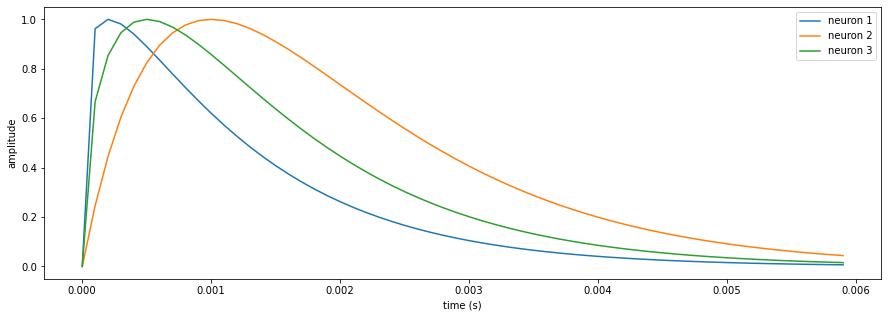

In [3]:
# Create spike waveforms
s1 = [gamma.pdf(0.01*x, 1.2, loc=0, scale=0.1) for x in range(60)]
s2 = [gamma.pdf(0.01*x, 2, loc=0, scale=0.1) for x in range(60)]
s3 = [gamma.pdf(0.01*x, 1.5, loc=0, scale=0.1) for x in range(60)]
s1/=max(s1)
s2/=max(s2)
s3/=max(s3)

# Plot waveforms 
sf = 10e3
time = np.arange(60)/sf
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(time,s1,label='neuron 1')
plt.plot(time,s2,label='neuron 2')
plt.plot(time,s3,label='neuron 3')
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend()
plt.show()

The function defined below uses these waveforms and a noise term to generate voltage records. Note that the voltage amplitude for each neuron is scaled to reflect different positions of the electrodes relative to the recorded neurons (i.e. if the neurons are closer to the electrodes, their amplitudes will be larger).

In [4]:
def generateRecords(nChannels, noise, manualStarts=None):
    '''Create multi-channel field recording.
    ------
    Inputs
    ------
    nChannels (int): number of recording channels
    noise (float): noise coefficient 
    manualStarts (list): list of spike start times. If not provided, will compute these.
    -------
    Outputs
    -------
    records (array): multi-channel recording 
    starts (array): spike start times 
    '''
    nSamps= 100000 # number of voltage samples 
    records = [] # contains recording channels 
    noise = noise*np.random.normal(size=nSamps) # recording noise
    scalings = [(random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)) \
              for i in range(nChannels)] # scales waveform amplitudes 

    # Don't compute spike times if they are already provided  
    if manualStarts:
        starts = manualStarts

    else:
        starts = [np.sort(np.random.randint(0,1600,20)*60) \
                for i in range(3)] # spike start times

    chunks = [[np.array([np.arange(s_i,s_i+60) for s_i in s[1:-1]])] \
            for s in starts] # spike events

    # Generate record for each electrode 
    for scale in scalings:
        c1,c2,c3 = scale # scaling coefficients 
        z = np.zeros(nSamps) # voltage trace
        z[tuple(chunks[0])] = s1*c1
        z[tuple(chunks[1])] = s2*c2
        z[tuple(chunks[2])] = s3*c3
        z = z + noise # add noise 
        records.append(z)

    records = np.array(records)

    return records, starts


### Question 1.1 [1]
Using this function, generate a plot of 10s of synthetic data for a tetrode (4 channels) with `noise = 0.05`  

In [5]:
nChannels = 4
noise = 0.05
records, starts = generateRecords(nChannels, noise)

### Question 1.2 [1.5]
Our goal is to identify different neurons in this noisy four-channel recording. To do this, we first need to extract spikes from the records. The function segmentSpikes extracts spikes and outputs an array "segSpikes," where each row corresponds to an extracted spike time series. 

In [6]:
def segmentSpikes(records, thresh, skip, manualTimes=None):
    '''Create multi-channel field recording.
    ------
    Inputs
    ------
    records (array): voltage recordings for all channels 
    thresh (list): z-score threshold for spike acceptance 
    skip (int): minimum time bins between consecutive spikes 
    manualTimes (list): list of spike start times. If not provided, will compute these.
    -------
    Outputs
    -------
    segSpikes (array): segmented spikes
    spikeTimes (array): spike start times 
    '''
    maxProject = np.max(records,axis=0) # max-projection of channels 
    locs = np.argwhere(zscore(maxProject) > thresh).flatten() # candidate spike positions
    spikeTimes = [0] # intialize list of spike times

    # Use manual times if provided. Otherwise, find spike times
    if manualTimes:
        spikeTimes = manualTimes

    else:
        for l in locs:
            if l > (spikeTimes[-1] + skip):
                spikeTimes.append(l)

    # Segment spikes
    segSpikes = np.array([maxProject[l-10:l+30] for l in spikeTimes[1:] \
                          if len(maxProject[l-10:l+30])==40])

    return segSpikes,spikeTimes



Generate a plot of your extracted spikes from the question above. How many different waveforms do you see? Why does this make ense?

**Hint**: A threshold of 2.56 and a skip value of 60 work well.



><font color="firebrick"> There seem to be three distinct waveforms (see figure below)

In [7]:
thresh = 3
skip = 50
segSpikes, spikeTimes = segmentSpikes(records, thresh, skip)

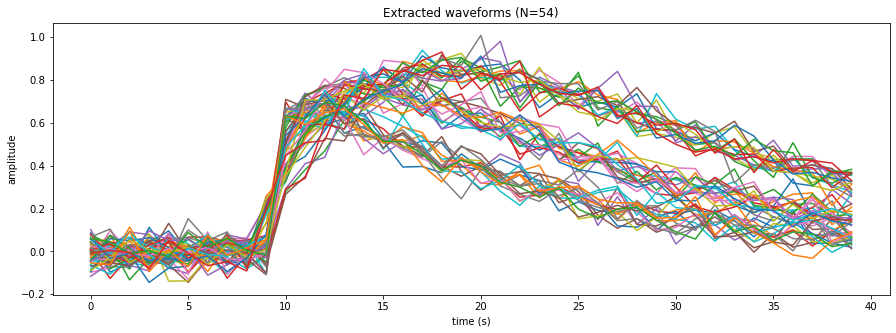

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Extracted waveforms (N={})'.format(segSpikes.shape[0]))
plt.plot(segSpikes.T)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

plt.show()

### Question 1.3 [3]

Now comes the fun part. Write a function that takes your "segSpikes" array and sorts these spikes into different groups. At a minimum, your function should return the predicted label for each extracted spike and generate a plot of the different spike waveforms and a plot of the first two principal components color-coded by group identity.

**Important:** Even though we know we are recording three neurons, do not make any assumptions about the number of groups to cluster: you should find a way to test a set of clusters and then quantitatively determine the optimal number. 

**Hint:** You may find PCA, KMeans, and silhouette_score code from sklearn to be helpful here. 

In [9]:
### PCA of the exctracted spike waveforms
def run_pca(data, n_components=2):
    '''
    Runs a PCA analysis for given data and number of components
    input:
        data (2d array) dat to be reduced
        n_components (int) number of componenets, default n=2
    output:
        transformed data (2d array)
    '''
    
    pca = PCA(n_components=n_components)
    X_t = pca.fit(data).transform(data)
    
    return X_t

In [10]:
def eval_optimal_k(data , k_range=range(2, 10)):

    '''
    Evaluating the best K using
    (1) Simple Inertia score
            The mean squared distance between each instance 
            and its closest centroid

            optimum = elbow(score)

    (2) Silhouette score
            Silhouette Coefficient = (x-y)/ max(x,y) where
            x is the mean intra-cluster distance
            y the mean nearest-cluster distance

            optimum = max(score)
            
    input:
        data (2d array) data to be clustered
        k_range (1d array) range of Ks to evaluate
    
    output:
        interia and silhouette scores for each k
    '''  

    inertia = {}
    sil_score = {}
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        labels = KMeans(n_clusters=k, max_iter=1000).fit_predict(data)
        inertia[k] = kmeans.inertia_ 
        sil_score[k] = metrics.silhouette_score(data, labels) 
    
    return inertia, sil_score

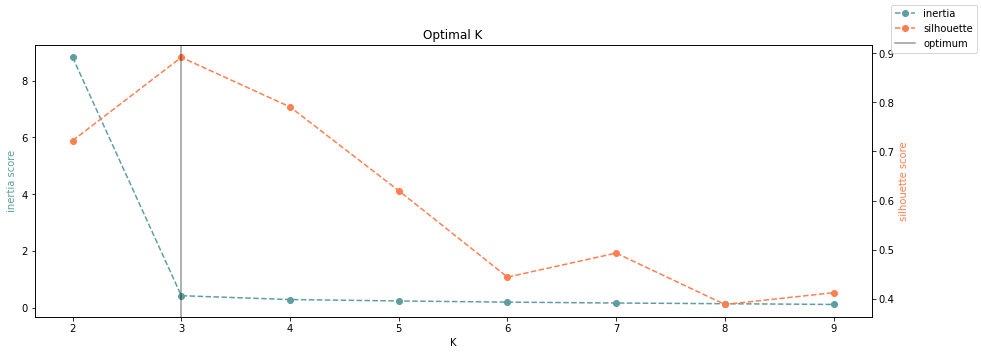

In [11]:
## calc clusters based on PCA and get scores
X_t = run_pca(segSpikes)
inertia, sil_score = eval_optimal_k(X_t)

##plot score per K
fig, ax1 = plt.subplots(figsize=(15,5))
plt.title('Optimal K')
ax1.plot(list(inertia.keys()), 
         list(inertia.values()), 
         '--r', marker='o',
        label = 'inertia',
        color='cadetblue')
ax2 = ax1.twinx() 

ax2.plot(list(sil_score.keys()), 
         list(sil_score.values()), 
         '--r', marker='o',
        label='silhouette',
        color='coral')

plt.axvline(x=3, alpha=.4, c='black', label='optimum')
fig.legend()

ax1.set_xlabel('K')
ax1.set_ylabel('inertia score', c='cadetblue')
ax2.set_ylabel('silhouette score', color='coral')

plt.show()

><font color="firebrick"> Notice the highlighted optimum: max silhouette score and elbow at the inertia curve - both point at K=3 as the optimized number of groups

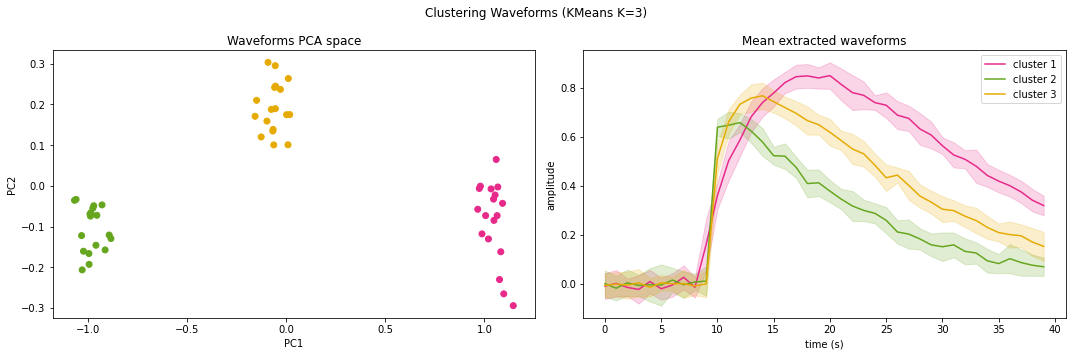

In [12]:
## plotting clusters, K=3

y_pred = KMeans(n_clusters=3).fit_predict(X_t)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Clustering Waveforms (KMeans K=3)')
ax[0].set_title('Waveforms PCA space')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[0].scatter(X_t[:,0], X_t[:,1], c=[colors[i+4] for i in y_pred])

ax[1].set_title('Mean extracted waveforms'.format(segSpikes.shape[0]))

ax[1].plot(np.mean(segSpikes[np.where(y_pred==0)[0]].T, axis=1), 
         label = 'cluster 1', c=colors[4])
ax[1].fill_between(range(0,40),np.mean(segSpikes[np.where(y_pred==0)[0]].T, axis=1) - np.std(segSpikes[np.where(y_pred==0)[0]].T, axis=1),
                   np.mean(segSpikes[np.where(y_pred==0)[0]].T, axis=1) + np.std(segSpikes[np.where(y_pred==0)[0]].T, axis=1),
          color=colors[4], alpha=.2)

ax[1].plot(np.mean(segSpikes[np.where(y_pred==1)[0]].T, axis=1), 
         label = 'cluster 2', c=colors[5])
ax[1].fill_between(range(0,40),np.mean(segSpikes[np.where(y_pred==1)[0]].T, axis=1) - np.std(segSpikes[np.where(y_pred==1)[0]].T, axis=1),
                   np.mean(segSpikes[np.where(y_pred==1)[0]].T, axis=1) + np.std(segSpikes[np.where(y_pred==1)[0]].T, axis=1),
          color=colors[5], alpha=.2)

ax[1].plot(np.mean(segSpikes[np.where(y_pred==2)[0]].T, axis=1), 
         label = 'cluster 3', c=colors[6])
ax[1].fill_between(range(0,40),np.mean(segSpikes[np.where(y_pred==2)[0]].T, axis=1) - np.std(segSpikes[np.where(y_pred==2)[0]].T, axis=1),
                   np.mean(segSpikes[np.where(y_pred==2)[0]].T, axis=1) + np.std(segSpikes[np.where(y_pred==2)[0]].T, axis=1),
          color=colors[6], alpha=.2)

ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('amplitude')

plt.legend()
plt.tight_layout()
plt.show()

### Question 1.4 [3]
You will now assess the effect of noise on the quality of your spike sorting. (1) Write a function called "analyze_noise" that takes an array of noise levels `(np.linspace(0.005, 0.4, 6))` and returns a metric that quantifies the grouping quality. (2) Plot that metric as a function of different noise levels. (3) Your function should also generate a plot of the color-coded waveforms and PC1/2 for each noise level (or call a second function that makes those plots).

**Hint:** If you are using KMeans to cluster your data, the silhouette score for each cluster assignment is a natural way to quantify sorting quality. In addition, reducing the dimensionality of your data (to say, 2 dimensions) will help you directly observe how noise infleunces your clusters. 

**Hint:** The way the function (`generateRecords`) was written for you above means that you should use the spike times from the first (lowest noise) iteration for the remaining interations. In other words, extract "starts" from generateRecords and "spikeTimes" from segmentSpikes for the lowest noise case. For all subsequent noise levels, feed "starts" into generateRecords and "spikeTimes" into segmentSpikes. 


In [13]:
def analyze_noise(data_gen_params, noise_levels, n_k):
    '''
    eval K means clustering (using Silhouette score) 
        for varying noise levels
        
    input:
      data_gen_params [nChannels, thresh, skip]  parameres to 
          generate and segment the data
      noise_levels (1d array) noise levels to evaluate
      n_k (int) Ks to evalaute starting at 2
      
    output:
        Silhouette score (2d array) for each noise level for each k 
    
    '''
    nChannels, thresh, skip = data_gen_params
    
    sil = np.zeros((noise_levels.shape[0], n_k))
    for noise_i, noise in enumerate(noise_levels):
        records, starts = generateRecords(nChannels, noise)
        segSpikes, spikeTimes = segmentSpikes(records, thresh, skip)

        pca = PCA(n_components=2)
        X_t = pca.fit(segSpikes).transform(segSpikes)

        for k in range(2, 2+n_k):

            labels = KMeans(n_clusters=k, max_iter=1000).fit_predict(X_t)
            sil[noise_i][k-2] = metrics.silhouette_score(X_t, labels)

    return sil

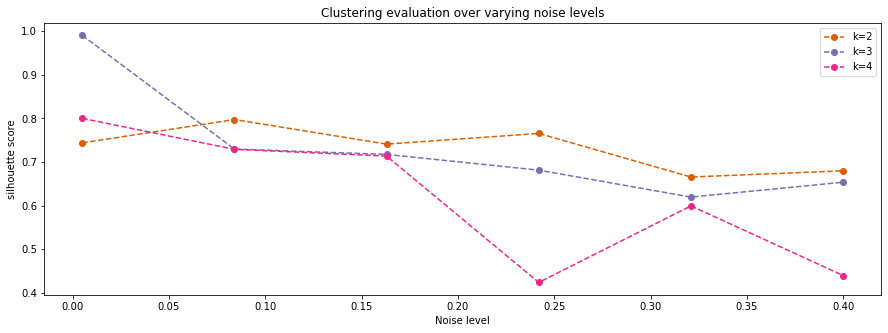

In [14]:
noise_sil = analyze_noise([4,3,50], np.linspace(0.005, 0.4, 6), 3)

fig, ax = plt.subplots(figsize=(15,5))
plt.title('Clustering evaluation over varying noise levels')

for k in range(2, 5):
    plt.plot(np.linspace(0.005, 0.4, 6), 
             noise_sil[:,k-2], 
             '--r', marker='o',
            label='k={}'.format(k), color=colors[k])
    

plt.legend()

plt.xlabel('Noise level')
plt.ylabel('silhouette score')

plt.show()

### Question 1.5 [2] 
Interpret your results from the noise analysis. 

**(1)** How does noise affect the quality of your spike sorting algorithm? Be sure to use your generated graphs and quantitative metric to support your argument. 

**(2)** List at least one way you may be able to improve the signal/noise ratio during extracellular recordings.


><font color="firebrick"> (1) Noise shows (mostly) an inverse correlation to the silhouette score. I.e., as the noise increases, the silhouette score decreases. Interestingly, the ranking of the optimized number of clusters (K) changes with noise- specifically, K=3 superiority diminishes with the increase of noise. 

 
><font color="firebrick"> (2) Generally, using a low noise amplifier supports minimizing additional noise generated by amplifying the signal itself. In extracellular recording, there is an unique noise stemming from the fact that the measurements are no direct but coming from adjacent cells. Thus, getting the electrode as close as possible to the target cell could help increase SNR. Additionally, using a low impedance electrode allow larger current to flow from the (weakly signaled) source to the electrodes.

### Question 1.6 [2]
Finally, you will assess the performance of your spike sorting algorithm as a function of the number of recorded channels. Write a function called "analyze_channels" that takes as input (1) a list containing the number of channels (between 2 and 10) and (2) a noise coefficient of 0.3. For each channel number, you should average your quality metric across at least 10 iterations in order to best observe the trend. Plot the average quality metric as a function of number of recorded channels.  

**Hint:** using a tqdm progress bar in your first for loop may be helpful here.

In [36]:
def analyze_n_channels(data_gen_params, varying_n_channels, n_k):
    '''
    eval K means clustering (using Silhouette score) 
        for varying noise levels
        
    input:
      data_gen_params [noise, thresh, skip]  parameres to 
          generate and segment the data
      varying_n_channels (1d array) n channels to evaluate
      n_k (int) Ks to evalaute starting at 2
      
    output:
        Silhouette score (2d array) for each noise level for each k 
    
    '''
    noise, thresh, skip = data_gen_params
    
    sil = np.zeros((20, len(list(varying_n_channels)), n_k))
    
    for i in range(20):
        
        for n_channels_i, n_channels in enumerate(varying_n_channels):
            records, starts = generateRecords(n_channels, noise)
            segSpikes, spikeTimes = segmentSpikes(records, thresh, skip)
            pca = PCA(n_components=2)
            X_t = pca.fit(segSpikes).transform(segSpikes)

            for k in range(2, 2+n_k):

                labels = KMeans(n_clusters=k, max_iter=1000).fit_predict(X_t)
                sil[i][n_channels_i][k-2] = metrics.silhouette_score(X_t, labels)

    return sil

In [55]:
# Silhouette score per channel
n_chans = [3,5,10,20,30,50,100]
n_chan_sil = analyze_n_channels([.3,3,50], n_chans, 3)


In [46]:
#plotting summary statistics
mean_n_chan_sil = np.mean(n_chan_sil, axis=0)
std_n_chan_sil = np.std(n_chan_sil, axis=0)

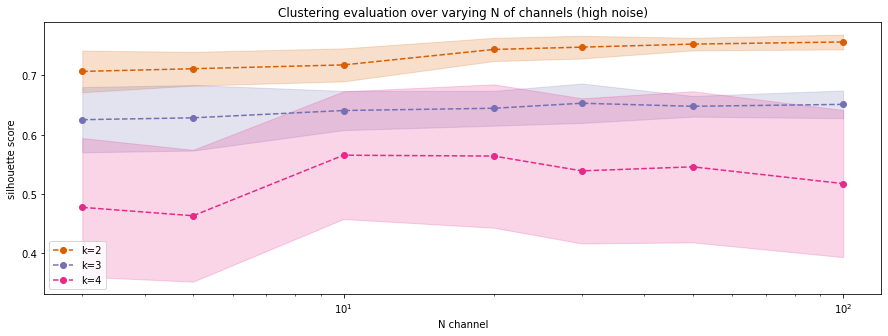

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
plt.title('Clustering evaluation over varying N of channels (high noise)')

for k in range(2, 5):
    plt.plot(n_chans, 
             mean_n_chan_sil[:,k-2], 
             '--r', marker='o',
            label='k={}'.format(k), color=colors[k])
    plt.fill_between(n_chans, 
        mean_n_chan_sil[:,k-2]- std_n_chan_sil[:,k-2],
        mean_n_chan_sil[:,k-2]+std_n_chan_sil[:,k-2],
      color=colors[k], alpha=.2)

plt.legend()
plt.xscale('log')
plt.xlabel('N channel')
plt.ylabel('silhouette score')

plt.show()

### Question 1.7 [2.5]
Interpret your results from the channel analysis. 

**(1)** Does increasing the number of channels improve your spike sorting algorithm according to your quality metric? Explain your observations.

><font color="firebrick"> Not majorly. However, there is a slight increase in silhouette score as the number of channels increases. This makes sense since the noise averages out with the increase of channels, so some signal is presumed to be detected. 

**(2)** How do you think your results would change if the noise level were much lower? Justify your answer. You may experiment with different noise levels in your "analyze_channels" function. 

><font color="firebrick"> Mostly, I expected to see the inverse of the figure above. Low noise implicates high SNR. More channels will make the recording less accurate (further from neurons, for one), decreasing the silhouette score. The figure below shows a small effect of that trend.
    
><font color="firebrick"> Notice, both figures show logged X axis.    

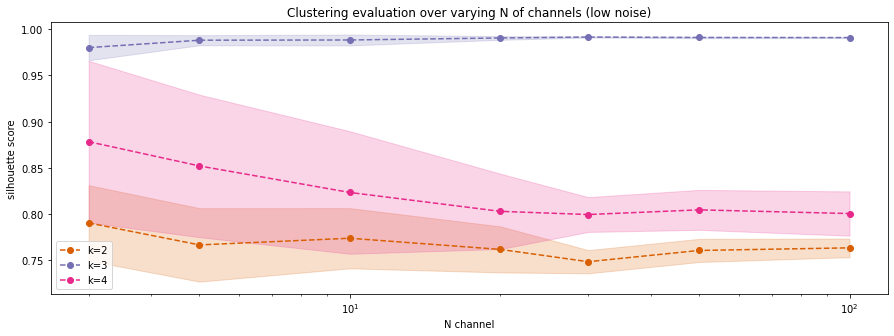

In [56]:
n_chan_sil_low_noise = analyze_n_channels([0.005,3,50], n_chans, 3)
mean_n_chan_sil_low_noise = np.mean(n_chan_sil_low_noise, axis=0)
std_n_chan_sil_low_noise = np.std(n_chan_sil_low_noise, axis=0)
fig, ax = plt.subplots(figsize=(15,5))

plt.title('Clustering evaluation over varying N of channels (low noise)')

for k in range(2, 5):
    plt.plot(n_chans, 
             mean_n_chan_sil_low_noise[:,k-2], 
             '--r', marker='o',
            label='k={}'.format(k), color=colors[k])
    plt.fill_between(n_chans, 
        mean_n_chan_sil_low_noise[:,k-2]- std_n_chan_sil_low_noise[:,k-2],
        mean_n_chan_sil_low_noise[:,k-2]+std_n_chan_sil_low_noise[:,k-2],
      color=colors[k], alpha=.2)

plt.legend()
plt.xscale('log')

plt.xlabel('N channel')
plt.ylabel('silhouette score')

plt.show()

## 2. Neural Encoding Models: fitting Gaussian and Poisson GLMs to spike train data [20] 

In ths problem you will go through the steps of fitting of a linear-Gaussian GLM
(also known as linear least-squares regression model) and a Poisson GLM
(aka  "linear-nonlinear-Poisson" model) to retinal ganglion cell spike
train data.

###The dataset###

This dataset contains spike trains from 4 retinal ganglion cells
(2 ON cells and 2 OFF cells) stimulated with a 1D binary stimulus sequence, aka "full-field flicker". The data were collected by Valerie Uzzell in EJ Chichilnisky's lab (relevant pub: Uzzell & Chichilnisky 2004)

NB: the dataset is provided for tutorial purposes only, and should not be
distributed or used for publication without express permission from EJ
Chichilnisky (ej@stanford.edu). 


###Loading the data###

The stimulus `Stim` is a length-144051 vector of stimulus values (-0.48 and +0.48 on each frame of the stimulus), which were presented at 119.8954 Hz (frame length = 8.3ms).  

The spike times have already been binned into 8.3ms time bins, so we have a 144051 x 4 matrix of spike counts, `SpCounts`, where each column corresponds to the spikes of a different neuron. 

In [20]:
# Load the data from the .mat file
from scipy.io import loadmat
RGCdata = loadmat('RGCdata.mat')

# Extract each relevant variable
stim = RGCdata['Stim'].squeeze()# binary stimulus time series
all_spikes = RGCdata['SpCounts'] # binned spike count data for 4 neurons
dt_stim = RGCdata['dtStim']     # the time bin size (if you want it for some reason)

frame_len = 8.3

In [21]:
## get spikes per channel
spikes0 = all_spikes[:, 0]
spikes1 = all_spikes[:, 1]
spikes2 = all_spikes[:, 2]
spikes3 = all_spikes[:, 3]

**2.1 Building the design matrix [3]**.

This is a necessary step before we can fit the model: assemble a matrix
that contains the relevant regressors for each time bin of the response,
known as a design matrix.  Each row of this matrix contains the relevant
stimulus chunk for predicting the spike count at a given time bin.

Note that for the first rows of the design matrix, you will need to "pad" the stimulus with zeros.  For example, if your filter is length 25, then for the first row of the design matrix (correponding to the first time bin of the response), you will insert the first stimulus value, and 24 zeros preceding it.  This corresponds to the fact that we have no stimulus values prior to the first time bin.  For the second row of the design matrix, you will have 2 stimulus values (from time bins 1 and 2), with 23 zeros before it. 

One additional suggestion: add one additional column of "all ones" to your design matrix, which will allow the model to incorporate a non-zero baseline firing rate.



In [22]:
# stimulus filter size: 
ntfilt = 25 

# design matrix
padded_stim = np.concatenate([np.zeros(ntfilt - 1), stim])

T = len(stim)  # Total number of timepoints
M = np.zeros((T, ntfilt))

for t in range(T):
      M[t] = padded_stim[t:t + ntfilt]
        


**2.2 Visualize the design matrix. [1]**  

Make an image plot visualizing the first 100 rows of the design matrix. Here you should notice a "diagonally striped" pattern, corresponding to the fact that every row of the design matrix looks like the row above, shifted over by 1 bin.  (Technically this is known as a Toeplitz or Hadamard matrix). 

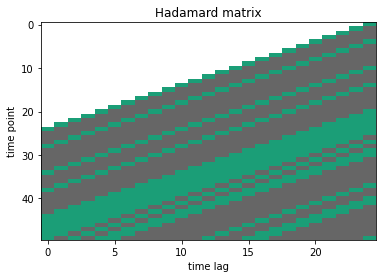

In [33]:
M_to_plot = M[:50].copy()

M_to_plot[M_to_plot==0]=np.nan


plt.clf() 
plt.imshow(M_to_plot/0.48, aspect='auto', interpolation='nearest', cmap='Dark2')
plt.title('Hadamard matrix')
plt.ylabel('time point')
plt.xlabel('time lag')


plt.show()


**2.3  Least-squares regression (linear-Gaussian GLM) [5]**.  
Select one of the neurons (1 through 4) and solve for the least-squares regression solution for the model filter using the formula $\hat w_{LS} = (X^T X)^{-1} X^T Y)$.   Note that this corresponds to the maximum-likelihood estimate for a linear encoding model with Gaussian noise (an example of a "general linear model"). 

In [24]:
# analytical solution for MLE for guassian noise
w_ls = lambda x,y: np.linalg.solve(x.T@x, x.T@y)

def get_x_y(M, stim, spikes):
    
    '''
    prepare the parts needed for the calculation: 
    
    Input:
        M (matrix) design matrix
        stim (array) input stimuli
        spikes (array) channel specific spikes
        
    Output:
        x (matrix) design matrix of stim+constant
        y (array) spikes
    '''
    
    y = spikes
    constant = np.ones((stim.shape[0],1))
    
    X = np.column_stack([constant, M])
    
    return X, y
    
    
def get_theta_gaussian(X, y, w_ls=w_ls):
    '''
    calculate the maximum likelihood guassian parameter (analytically)
    
    Input:
    
        x (matrix) design matrix of stim+constant
        y (array) spikes
        
    Output:
        theta (array) guassian parameter 
    '''

    #MLE weights for GLM model (with gaussian noise)
    theta_G = w_ls(X, y)
    
    return theta_G


In [25]:
def plot_predicted_spike_counts(y, yhat, title, t0=30, nt=50, 
                                ntfilt=ntfilt, frame_len=frame_len):
    '''
    plot the true and predicted spike count
    
    Input:
        y (array) true spikes
        yhat (array) GLM predicted spikes
        title (string) plot title
        t0 (int) starting time to plot
        nt (int) numnber of timepoints to plot
        ntfilt (int) filter size
        frame_len (float) fram rate in ms
        
    No output, just plots
        
    '''
    fig, ax = plt.subplots(figsize=(15,3))
    plt.title(title)

    
    t = np.arange(t0, t0+nt) * ntfilt * frame_len /1000
    lines = ax.stem(t, y[t0:t0+nt], use_line_collection=True, label='spikes')

    plt.setp(lines, color=".5")

    plt.plot(t, yhat[t0:t0+nt], label='prediction', color=colors[3])

    plt.xlabel('time (s)')
    plt.ylabel('spikes')

    plt.legend()
    plt.show()


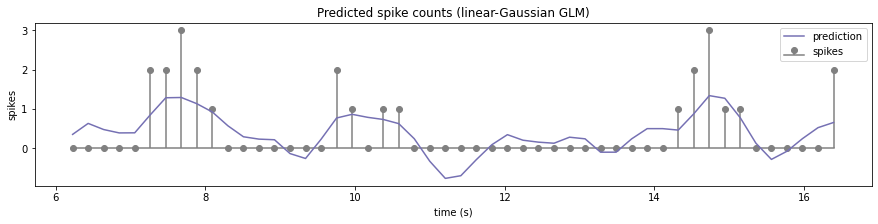

In [26]:
X, y2 = get_x_y(M, stim, spikes2)
theta_G_2 = get_theta_gaussian(X, y2)

yhat_G_2 = X @ theta_G_2    
plot_predicted_spike_counts(y2, yhat_G_2, 
                            'Predicted spike counts (linear-Gaussian GLM)')


**2.4 Fitting a Poisson GLM [5]**. 

Use either `statsmodels.api.GLM` or `pyglmnet` to fit a Poisson Generalized Linear Model (GLM) using the same design matrix and response vector you selected above.  (Note you will need to read the help on how to use these packages, as I haven't done this before... google is your friend here!).  I would expect the default behavior to be that the function will take in X, and Y, and an argument indicating that the noise distribution is Poisson, and return a maximum likelihood estimate of the parameters (or weights) $\hat w_{GLM}$. Typically the default assumption is that the nonlinearity is `exp`, which is equivalent to saying the "link" function (the inverse of the nonlinearity) is `log`.

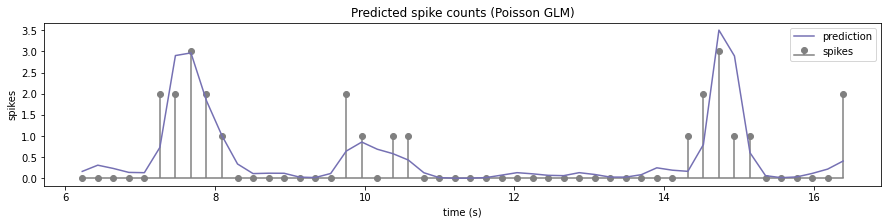

In [27]:
# get x/y for channel 2
X, y2 = get_x_y(M, stim, spikes2)

def get_theta_poisson(X, y):
    '''
    calculate the maximum likelihood poisson parameter (numerically via statsmodels)
    
    Input:
    
        x (matrix) design matrix of stim+constant
        y (array) spikes
        
    Output:
        theta (array) poisson parameter 
    '''
    # make a Poisson model
    pois_model = sm.GLM(y, X,
                       family=sm.families.Poisson())
    pois_results = pois_model.fit()

    # get theta_P_2 and predict the Y
    theta = pois_results.params
    
    return theta

theta_P_2 = get_theta_poisson(X, y2)
yhat_P_2 = np.exp(X @ theta_P_2)

plot_predicted_spike_counts(y2, yhat_P_2, 
                            'Predicted spike counts (Poisson GLM)')



**2.5 Plot the filter estimates [1]**   

Plot the two maximum likelihood filter estimates that you computed in the previous two problems.  Do they look the similar?  

(If desired, repeat steps 4.3-4.4 using a different one of the 4 neurons, and replot the filters. Observe how these filters differ between ON and OFF cells!)

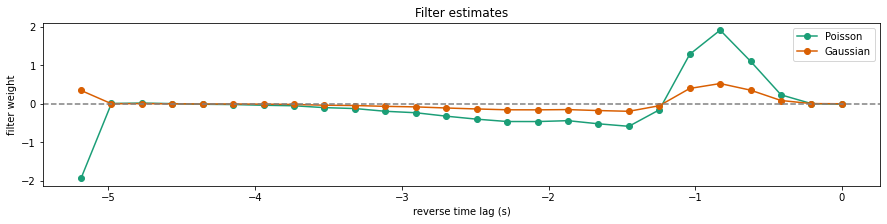

In [28]:
def plot_filters(theta_P, theta_G, colors=colors, ntfilt=ntfilt):
    '''
    plot the gussian and poisson filters
    
    Input:
        theta_P (array) Poisson param
        theta_G (array) Guassian param
        colors (array) color map
        ntfilt (int) filter size
        
    No output, just plots
        
    '''
    fig, ax = plt.subplots(figsize=(15,3))
    t = np.arange(-len(theta_P)+1, 1) * ntfilt * frame_len /1000

    
    plt.title('Filter estimates')

    plt.plot(t, theta_P, 
             marker="o", color=colors[1], 
             label='Poisson')

    plt.plot(t, theta_G, 
             marker="o",  color=colors[2], 
             label='Gaussian')


    plt.axhline(y=0, color='grey', linestyle='--')

    plt.xlabel("reverse time lag (s)")
    plt.ylabel("filter weight")

    plt.legend()
    plt.show()
    
plot_filters(theta_P_2, theta_G_2)

**2.6 Plot "predicted" firing rates [5]**

Compute the predicted firing rate for the first 1 second of training data.  For the linear-Gaussian GLM you can do this by simply multiplying the first 120 rows of the design matrix by the inferred weights.  For the Poisson GLM, do the same thing, and then pass the resulting vector through the point nonlinearity (eg `exp`).  

Make a single plot showing the firing rate predictions of the two models, along with the binned spike counts, for this first 1s of data.  (So your plot should have 3 traces in it).  How do the two predictions compare?

(Ideally, we would have liked to compute this prediction on test data, so that we aren't using the same data for fitting as for testing the model.  In this case, we would have divied the design matrix and response vector into two pieces, say 90% and 10%.  Fit the weights using 90% of the data, then plot predicitons on the "held-out" 10%.  We'll leave this as a bonus exercise if you'd like to do that and compute which model has lower mean-squared error on test data). 

In [29]:
# make groups for LOGO (leave one group out)cross validation

n_groups = 20
n_per_group = int(X.shape[0]/n_groups)
groups_l = []
for i in range(n_groups):
    groups_l.append([i]*n_per_group)
    
left_over = X.shape[0] -n_per_group*n_groups
groups_l.append([i]*left_over)
    
groups = np.array([item for sublist in groups_l for item in sublist])

# split data to LOGO groups
logo = LeaveOneGroupOut()

y_preds = []

#for each group, fit model params (theta) with all other groups, 
# and test on the one left out
for train_index, test_index in tqdm(logo.split(X, y2, groups)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y2[train_index], y2[test_index]
    
    pois_model_i = sm.GLM(y_train, X_train,
                   family=sm.families.Poisson())
    
    pois_results_i = pois_model_i.fit()
    theta_P_2_i = pois_results_i.params

    yhat_P_2_i = np.exp(X_test @ theta_P_2_i)

    y_preds.append(yhat_P_2_i)

20it [00:15,  1.29it/s]


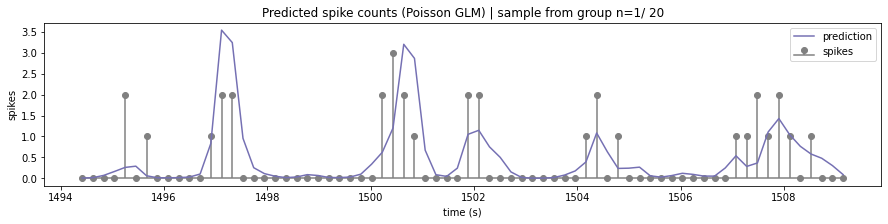

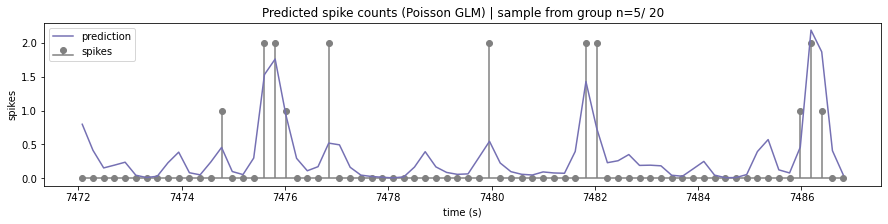

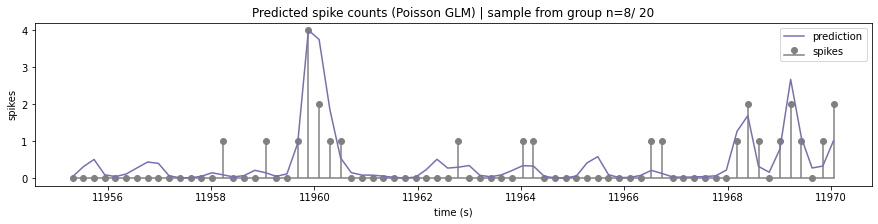

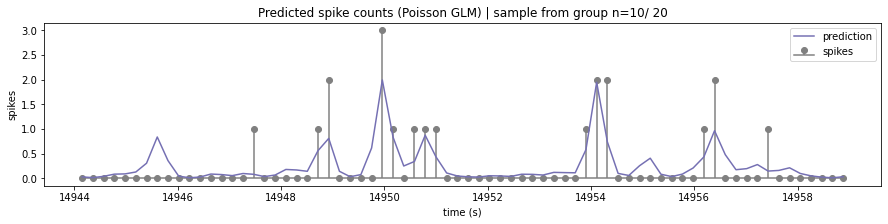

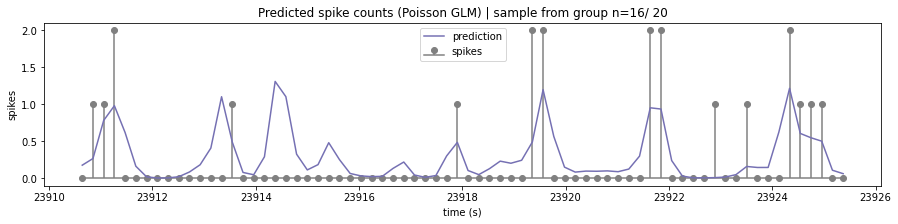

In [30]:
y_preds_array = np.array([item for sublist in y_preds for item in sublist])

## sample predicted spike from LOGO:
for i in [1,5,8,10,16]:
    t0=n_per_group*i
    nt=int(n_per_group/100)
    
    title = 'Predicted spike counts (Poisson GLM) | sample from group n={}/ {}'.format(i, n_groups)
    
    plot_predicted_spike_counts(y2, y_preds_array, title, t0, nt)



In [31]:

def plot_side_by_side_predicted_spike_counts(y, yhat1, yhat2, 
                                title='Predicted spike counts (linear-Gaussian & Poisson GLM)', 
                                t0=0, nt=50, 
                                ntfilt=ntfilt, frame_len=frame_len):
    '''
    Compare Guassian and Poisson models
    
    Input:
        y (array) true spikes
        yhat1 (array) GLM predicted spikes model 1
        yhat2 (array) GLM predicted spikes model 2
        t0 (int) starting time to plot
        nt (int) numnber of timepoints to plot
        ntfilt (int) filter size
        frame_len (float) fram rate in ms
        
    No output, just plots
        
    '''
    fig, ax = plt.subplots(figsize=(15,3))
    plt.title(title)

    t = np.arange(t0, t0+nt) * ntfilt * frame_len /1000

    lines = plt.stem(t, y[t0:t0+nt], use_line_collection=True, label='spikes')

    plt.setp(lines, color=".5")

    plt.plot(t, yhat1[t0:t0+nt], label='prediction Guassian', color=colors[2])
    plt.plot(t, yhat2[t0:t0+nt], label='prediction Poisson', color=colors[1])

    plt.xlabel('time (s)')
    plt.ylabel('spikes')
    
    
    plt.legend()
    plt.show()




><font color="firebrick"> Plotting all four channels, their ON / OFF properties are easily observable. See the filters plotted below, the first 2 channels show a negative filter for a stimulus whaeares the last 2 show a positive one.



Channel 0:


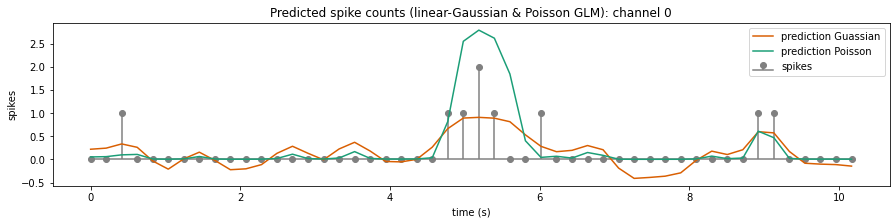

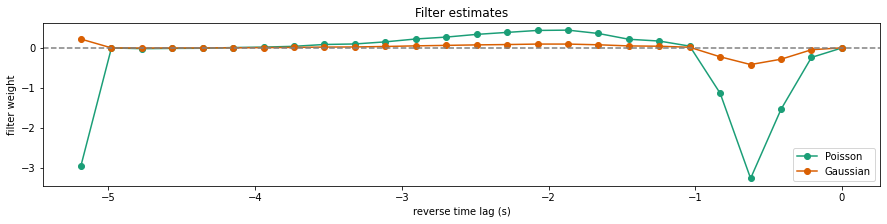

Channel 1:


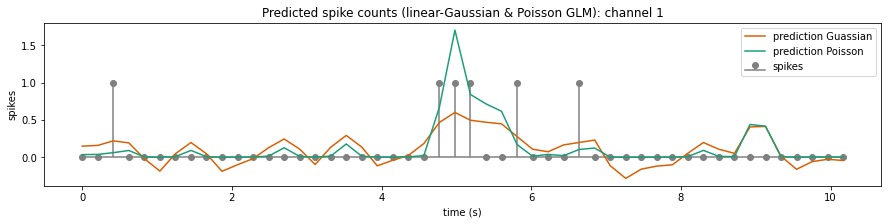

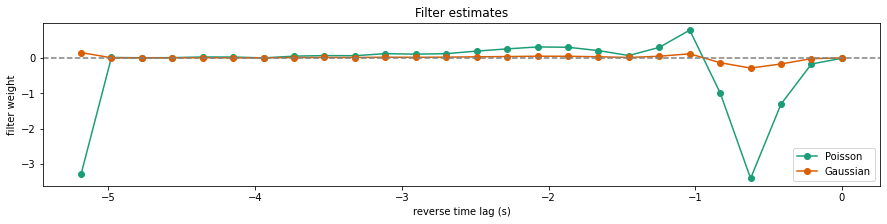

Channel 2:


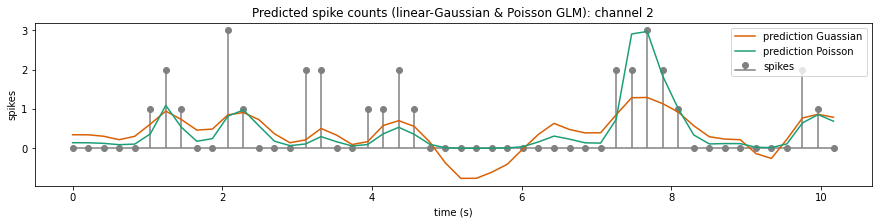

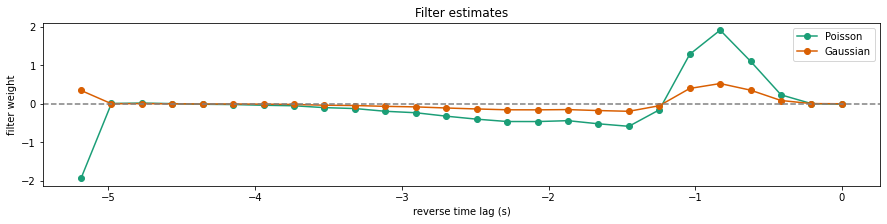

Channel 3:


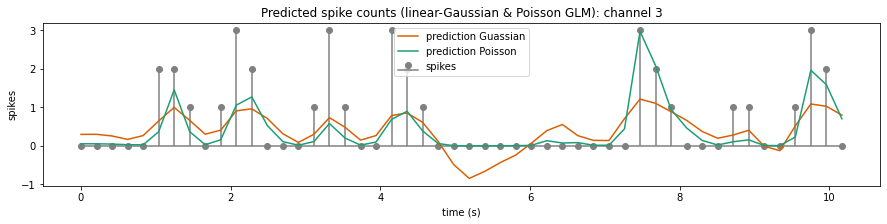

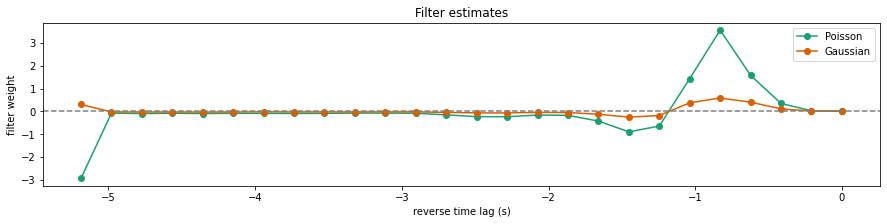

In [35]:
for i,spikes in enumerate([spikes0, spikes1, spikes2, spikes3]):

    X, y = get_x_y(M, stim, spikes)

    ### GAUSSIAN
    theta_G = get_theta_gaussian(X, y)
    yhat_G = X @ theta_G   

    ##POISSON
    theta_P = get_theta_poisson(X, y)
    yhat_P =  np.exp(X @ theta_P)
    
    
    print('Channel {}:'.format(i))
    # COMPARE
    plot_side_by_side_predicted_spike_counts(y, yhat_G, yhat_P, 
                                    'Predicted spike counts (linear-Gaussian & Poisson GLM): channel {}'.format(i))
    plot_filters(theta_P, theta_G)


